In [1]:
import optuna
import Optimization as OP
import FrameworkLib as FL
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx   
import os
from IPython.display import clear_output
import matplotlib.animation as animation
from IPython.display import HTML

N_agents = 10
max_dist = 3
rigidity_threshold = 1e-4
box_margin = 10
seed = 0
random.seed(seed)
np.random.seed(seed)

conn = False
while conn==False:
    pos = {i: (random.uniform(0, box_margin), random.uniform(0, box_margin)) for i in range(N_agents)}        
    pos = np.array(list(pos.values()))
    pos.reshape(N_agents, 2)        
    G = FL.generate_graph(pos,max_dist) 
    isrigid = FL.is_rigid(G, 0.1*rigidity_threshold) 
    
    if nx.is_connected(G) and isrigid:
        conn = True        
        pos0 = np.copy(pos)
        G0 = FL.generate_graph(pos0,max_dist)
        

In [2]:
# study setup
search_margin = 1
Niter = 100
n_cycles = 40
alpha_contract = 0.8
alhpa_expand = 0.2
alpha_array = np.concatenate((alpha_contract*np.ones(n_cycles//4), 
                              alhpa_expand*np.ones(n_cycles//2), 
                              alpha_contract*np.ones(n_cycles//4)))

sampler = optuna.samplers.NSGAIISampler(constraints_func=OP.Objective.constraints, seed=0)
# Set Optuna logging level to WARNING to suppress output
optuna.logging.set_verbosity(optuna.logging.WARNING)

# storage
pos_replay = []
neighbors_replay = []
alpha_replay = []
cycle_replay = []
agent_replay = []
solution_found = []
constraints = []
pos_mov_replay = []
pos_opt_replay = []
J_edge_replay = []
J_coverage_replay = []

# cycle
for cycle in range(n_cycles):  
    
    # each node
    for node_number in range(len(G.nodes)):
        
        # the first is the fixed node
        agent_replay.append(node_number)
        if node_number != 0 or True:
            
            cov = FL.get_coverage(G)
            print(f'cycle: {cycle}, node: {node_number}, alpha: {alpha_array[cycle]}, coverage: {cov:.4f}')
            
            pos_opt = []
            pos_move = []
            pos_fix = []
            pos_sub = []
            
            # get neighborhood
            node = list(G.nodes)[node_number]
            neighbors = list(G.neighbors(node))
            N_agents_neighbor = len(neighbors)+1
            pos_sub = np.array([pos[neighbor] for neighbor in neighbors] + [pos[node]])
            pos_fix = pos_sub[:N_agents_neighbor-1,:]
            pos_fix = pos_fix.flatten()
            pos_mov = pos_sub[N_agents_neighbor-1,:]
            pos_mov = pos_mov.flatten()
            box_margin_mov = np.array([max(0,pos_mov[0]-search_margin),
                                    min(box_margin,pos_mov[0]+search_margin),
                                    max(0,pos_mov[1]-search_margin),
                                    min(box_margin,pos_mov[1]+search_margin)])
            
            # create study
            study = optuna.create_study(
            directions=["maximize"],
            sampler=sampler,
            study_name="subset_agents",
            storage=None,
            load_if_exists=False,
            )
            op = OP.Objective(N_agents_neighbor,max_dist,rigidity_threshold,box_margin_mov,alpha_array[cycle])  
            
            # set fix positions
            op.pos_fix = pos_fix            
            
            # optimize
            study.optimize(op.objective_function, n_trials=Niter, n_jobs=8, timeout=600, show_progress_bar=False)
            clear_output(wait=True) 
            
            # handle feasibility
            
            if len(study.best_trials) > 0:                                       
                pos_opt = np.array(list(study.best_trial.params.values())) 
                constraints_tmp = np.array(study.best_trial.system_attrs.get('constraints'))                
                solution_found_tmp = True                
            else: #! if there is no solution better than the initial one, there is still a best_trial (x0) BUT the constraints MIGHT be ok from before                
                pos_opt = pos_mov
                constraints_tmp = np.array(op.constraint_function(pos_opt))
                solution_found_tmp = False
                
            # update positions
            pos[node,:] = pos_opt
            
            # update graph
            G = FL.generate_graph(pos,max_dist)
                
            # append
            constraints.append(constraints_tmp)
            solution_found.append(solution_found_tmp)
            
            # save data
            pos_replay.append(np.copy(pos))
            pos_mov_replay.append(np.copy(pos_mov)) 
            pos_opt_replay.append(np.copy(pos_opt)) 
            alpha_replay.append(alpha_array[cycle])
            cycle_replay.append(cycle)
            neigh_tmp = np.array([pos[neighbor] for neighbor in neighbors] + [pos[node]])
            neighbors_replay.append(neigh_tmp)
            J_edge_replay.append(op.J_edge)
            J_coverage_replay.append(op.J_coverage)

cycle: 39, node: 9, alpha: 0.8, coverage: 31.2646


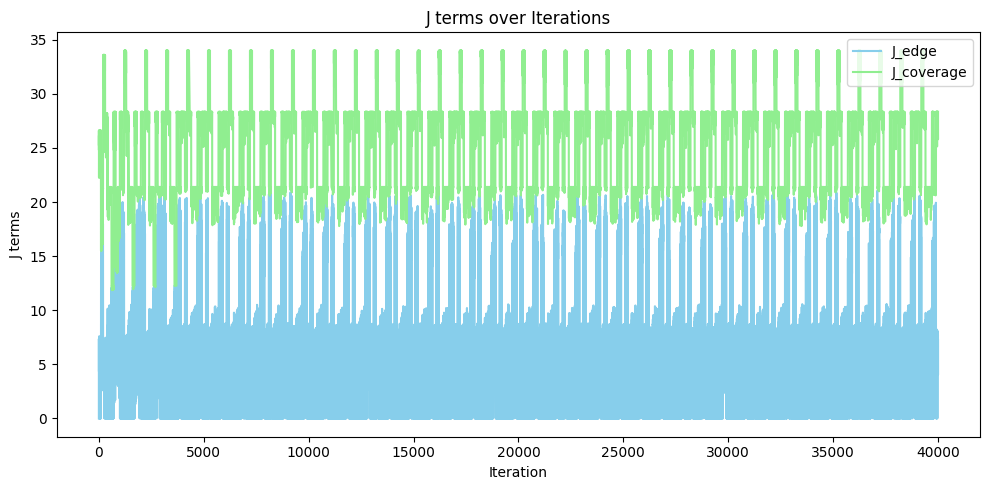

In [3]:
# Assuming op is already defined in the previous cells
plt.figure(figsize=(10, 5))

# Plot J_edge
plt.plot(np.array(J_edge_replay).reshape(-1), label='J_edge', color='skyblue')
plt.plot(np.array(J_coverage_replay).reshape(-1), label='J_coverage', color='lightgreen')
# plt.plot(J_edge_replay[0], label='J_edge')
# plt.plot(J_coverage_replay[0], label='J_coverage')
plt.xlabel('Iteration')
plt.ylabel('J terms')
plt.title('J terms over Iterations')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.rcParams['animation.embed_limit'] = 100  # Set the embed limit to 100 MB

def animate(i, pos_replay, coverage, edge_relation, alpha_replay, cycle_replay):
    
    # style
    trans = 0.4
        
    # get data
    pos_i = pos_replay[i]
    G_replay = FL.generate_graph(pos_i, max_dist)    
    isrigid, egvl_rig = FL.is_rigid(G_replay, rigidity_threshold)
    cov_tmp = FL.get_coverage(G_replay)
    edge_tmp = FL.get_edge_relation(G_replay)
    
    # add data    
    coverage.append(cov_tmp)
    edge_relation.append(edge_tmp)
        
    if isrigid:
        color_rigid = 'gray'
    else:
        color_rigid = 'red'    
    if alpha_replay[i] <= 0.2:
        color_alpha = 'lightgreen'
    elif alpha_replay[i] >= 0.8:
        color_alpha = 'skyblue'
    else:   
        color_alpha = 'darkgray'
        
    ax1.clear()   
    ax1.grid(True)   
    ax1.set_xlim([0, 20])
    ax1.set_ylim([5, 50])   
    
    # alpha text
    ax1.text(0.9, 0.95, 
             f'Alpha: {alpha_replay[i]}', 
             transform=ax1.transAxes, 
             fontsize=14, 
             color=color_alpha,
             verticalalignment='top', 
             horizontalalignment='center') 
    
    # info
    ax1.text(0.5, 1.05, f'Cycle: {cycle_replay[i]} EGVL: {egvl_rig:.4f}', 
             transform=ax1.transAxes, 
             fontsize=12, 
             color=color_rigid,
             verticalalignment='top', 
             horizontalalignment='center')        

    # also style
    if len(coverage) > 1:        
        color_scatter = ['black'] + ['lightgray'] * (len(edge_relation) - 2) + [color_rigid]        
        size = 100 * np.ones(len(edge_relation))
        size[0] = 400
        size[-1] = 400
    else:
        color_scatter = ['black'] + [color_rigid] * (len(edge_relation) - 1)
        size = 400 * np.ones(len(edge_relation))        
    alpha_scatter = trans * np.ones(len(edge_relation))
    alpha_scatter[-1] = 1
    alpha_scatter[0] = 1
    edge_color = ['white'] * len(edge_relation)
    
    ax1.scatter(edge_relation, coverage, 
                color=color_scatter, 
                s=size, 
                edgecolors=edge_color, 
                alpha=alpha_scatter, 
                linewidths=2)    
    fig3.tight_layout()
    return fig3

fig3, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
ax1.clear()
ax1.set_xlabel('Edge Relation')
ax1.set_ylabel('Coverage')    
coverage = []
edge_relation = []
ani_R = animation.FuncAnimation(fig=fig3, 
                              func=animate, 
                              frames=len(pos_replay), 
                              fargs=(pos_replay, coverage, edge_relation, alpha_replay, cycle_replay), 
                              interval=1000)
HTML(ani_R.to_jshtml())

In [ ]:
name_R = f'N{N_agents}_D{max_dist}_IT{Niter}_CYC{n_cycles}_EGV{rigidity_threshold}_ALPHA{alpha_contract}{alhpa_expand}_SEARCH{search_margin}\
    NORM_LENGTH_rels.gif'
if os.path.exists('results/' + name_R):
    os.remove('results/' + name_R)
ani_R.save('results/' + name_R, writer='pillow', fps=5)

In [ ]:
plt.rcParams['animation.embed_limit'] = 100  # Set the embed limit to 100 MB

def animate(i, pos_replay, alpha_replay, cycle_replay, agent_replay, neighbors_replay, solution_found):
        
    pos_i = pos_replay[i]
    G_replay = FL.generate_graph(pos_i, max_dist)
    isrigid, egvl_rig = FL.is_rigid(G_replay, rigidity_threshold)
    
    neighbors_i = neighbors_replay[i]
    G_neighbors = FL.generate_graph(neighbors_i, max_dist)    
    isrigid_neighbor, egvl_rig_neighbor = FL.is_rigid(G_neighbors, rigidity_threshold)
    box = plt.Rectangle((0, 0), box_margin, box_margin, fill=True, edgecolor='black', linestyle='-', facecolor='white', linewidth=2)            
    
    # colors
    if isrigid_neighbor:
        node_neighbor = ['darkgrey'] * (len(neighbors_i) - 1) + ['black']
        edge_neighbor = 'black'
    else:
        node_neighbor = ['orange'] * (len(neighbors_i) - 1) + ['red']
        edge_neighbor = 'red'
    if isrigid:
        color_rigid = 'gray'
    else:
        color_rigid = 'red'
    if solution_found[i] == False:
        color_optimization_found = 'red'
    else:
        color_optimization_found = 'lightgray'
    if alpha_replay[i] >= 0.8:
        color_alpha = 'skyblue'
    elif alpha_replay[i] <= 0.2:
        color_alpha = 'lightgreen'
    else:   
        color_alpha = 'darkgray'
        
    box_optimization_found = plt.Rectangle((0.01*box_margin, 0.89*box_margin), 
                                           0.1*box_margin, 0.1*box_margin, 
                                           fill=True, 
                                           alpha=0.8,
                                           edgecolor=color_optimization_found, 
                                           linestyle='-', facecolor=color_optimization_found, linewidth=2)

    # Configure x-ticks
    ax1.clear()
    ax1.set_xlim(-box_margin/10, box_margin+box_margin/10)
    ax1.set_ylim(-box_margin/10,box_margin+box_margin/10)
    ax1.add_patch(box)   
    ax1.add_patch(box_optimization_found) 
    nx.draw_networkx(G_replay, 
                     pos=nx.get_node_attributes(G_replay, 'pos'), 
                     with_labels=False, node_color=['lightgray'] + ['lightgray'] * (N_agents - 1), 
                     edge_color='gray', 
                     ax=ax1, 
                     hide_ticks=False, 
                     node_size=600,
                     width=2)
    nx.draw_networkx(G_neighbors,
                     pos=nx.get_node_attributes(G_neighbors, 'pos'), 
                     with_labels=False, node_color=node_neighbor,
                     edge_color=edge_neighbor, 
                     ax=ax1, 
                     hide_ticks=False, 
                     node_size=200, 
                     width=2)
    ax1.grid(True)  
    
    # alpha text
    ax1.text(0.5, 0.97, 
             f'Alpha: {alpha_replay[i]}', 
             transform=ax1.transAxes, 
             fontsize=14, 
             color=color_alpha,
             verticalalignment='top', 
             horizontalalignment='center') 
              
    # info
    ax1.text(0.5, 1.05, 
             f'Cycle: {cycle_replay[i]} Agent: {agent_replay[i]} EGVL: {egvl_rig:.4f} EGVL Neighbor: {egvl_rig_neighbor:.4f}', 
             transform=ax1.transAxes, 
             fontsize=12, 
             color=color_rigid,
             verticalalignment='top', 
             horizontalalignment='center')        
    fig2.tight_layout()
    return fig2

fig2, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
ax1.set_xlabel('Edge Relation')
ax1.set_ylabel('Coverage')    
coverage = []
edge_relation = []
ani_G = animation.FuncAnimation(fig=fig2, 
                              func=animate, 
                              frames=len(pos_replay), 
                              fargs=(pos_replay, alpha_replay, cycle_replay, agent_replay, neighbors_replay, solution_found), 
                              interval=1000)
HTML(ani_G.to_jshtml())

In [ ]:
name_G = f'N{N_agents}_D{max_dist}_IT{Niter}_CYC{n_cycles}_EGV{rigidity_threshold}_ALPHA{alpha_contract}{alhpa_expand}_SEARCH{search_margin}\
    NORM_LENGTH_graphs.gif'
if os.path.exists('results/' + name_G):
    os.remove('results/' + name_G)
ani_G.save('results/' + name_G, writer='pillow', fps=5)